# Lab 8: Object recognition with convolutional neural networks
In this lab we consider the [CIFAR dataset](https://www.openml.org/d/40926), but model it using convolutional neural networks instead of linear models.
There is no separate tutorial, but you can find lots of examples in the lecture notebook on convolutional neural networks.

Tip: You can run these exercises faster on a GPU (but they will also run fine on a CPU). If you do not have a GPU locally, you can upload this notebook to Google Colab. You can enable GPU support at “runtime” -> “change runtime type”.

In [1]:
import tensorflow as tf
import os
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

In [2]:
%matplotlib inline
import openml as oml
import matplotlib.pyplot as plt

In [3]:
# Download CIFAR data. Takes a while the first time.
# This version returns 3x32x32 resolution images. 
# If you feel like it, repeat the exercises with the 96x96x3 resolution version by using ID 41103 
cifar = oml.datasets.get_dataset(40926) 
X, y, _, _ = cifar.get_data(target=cifar.default_target_attribute, dataset_format='array'); 
cifar_classes = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer",
                 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

In [4]:
# The data is in a weird 3x32x32 format, we need to reshape and transpose
Xr = X.reshape((len(X),3,32,32)).transpose(0,2,3,1)

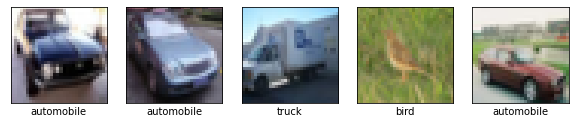

In [5]:
# Take some random examples, reshape to a 32x32 image and plot
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,len(Xr))
    # The data is stored in a 3x32x32 format, so we need to transpose it
    axes[i].imshow(Xr[n]/255)
    axes[i].set_xlabel((cifar_classes[int(y[n])]))
    axes[i].set_xticks(()), axes[i].set_yticks(())
plt.show();

## Exercise 1: A simple model
* Split the data into 80% training and 20% validation sets
* Normalize the data to [0,1]
* Build a ConvNet with 3 convolutional layers interspersed with MaxPooling layers, and one dense layer.
    * Use at least 32 filters in the first layer and ReLU activation.
    * Otherwise, make rational design choices or experiment a bit to see what works.
* You should at least get 60% accuracy.
* For training, you can try batch sizes of 64, and 20-50 epochs, but feel free to explore this as well
* Plot and interpret the learning curves


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xr,y, stratify=y, train_size=0.8)

In [7]:
from tensorflow.keras.utils import to_categorical
X_train = X_train / 255.
X_test = X_test / 255.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [8]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=25, batch_size=64, verbose=0,
                    validation_data=(X_test, y_test))

Metal device set to: Apple M1 Pro


Max val_acc 0.6492500305175781


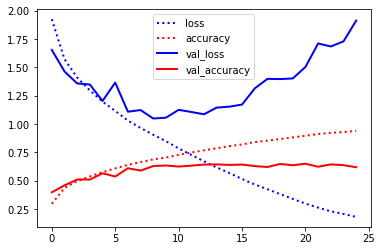

In [9]:
import pandas as pd
import numpy as np
pd.DataFrame(history.history).plot(lw=2,style=['b:','r:','b-','r-']);
print("Max val_acc",np.max(history.history['val_accuracy']))

Already decent performance but the model starts overfitting heavily after epoch 15.

## Exercise 2: VGG-like model
* Mimic the VGG model by building 3 'blocks' of 2 convolutional layers each
* Do MaxPooling after each block
* The first layer should have at least 32 filters
* Use zero-padding to be able to build a deeper model
* Use a dense layer with at least 128 hidden nodes.
* Plot and interpret the learning curves


In [10]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=25, batch_size=64, verbose=0,
                    validation_data=(X_test, y_test))

Max val_acc 0.6827500462532043


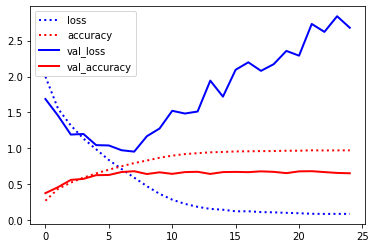

In [11]:
pd.DataFrame(history.history).plot(lw=2,style=['b:','r:','b-','r-']);
print("Max val_acc",np.max(history.history['val_accuracy']))

Better result, but still overfitting heavily

## Exercise 3: Regularization
* Explore different ways to regularize your VGG-like model
  * Try adding some dropout after every MaxPooling and Dense layer.
    * What are good Dropout rates?
  * Try batch nornmalization together with Dropout
* Plot and interpret the learning curves


In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=25, batch_size=64, verbose=0,
                    validation_data=(X_test, y_test))

Max val_acc 0.7305000424385071


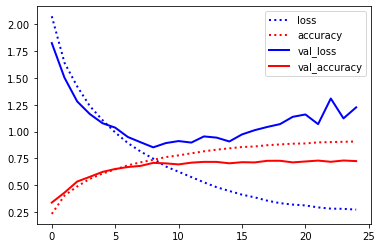

In [13]:
pd.DataFrame(history.history).plot(lw=2,style=['b:','r:','b-','r-']);
print("Max val_acc",np.max(history.history['val_accuracy']))

Accuracy is quite a bit better and overfitting seems lessened

Another common approach is to gradually increase the amount of dropout. This forces layers deep in the model to regularize more than layers closer to the input.

In [14]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=25, batch_size=64, verbose=0,
                    validation_data=(X_test, y_test))

Max val_acc 0.7412500381469727


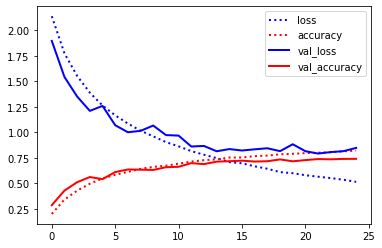

In [15]:
pd.DataFrame(history.history).plot(lw=2,style=['b:','r:','b-','r-']);
print("Max val_acc",np.max(history.history['val_accuracy']))

Slightly better accuracy and very little overfitting remains.

Next, we try adding Batch Normalization.

In [16]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=25, batch_size=64, verbose=0,
                    validation_data=(X_test, y_test))

Max val_acc 0.7827500104904175


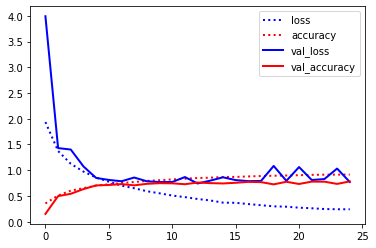

In [17]:
pd.DataFrame(history.history).plot(lw=2,style=['b:','r:','b-','r-']);
print("Max val_acc",np.max(history.history['val_accuracy']))

## Exercise 4: Data Augmentation
* Perform image augmentation. You can use the ImageDataGenerator for this.
* What is the effect? What is the effect with and without Dropout?
* Plot and interpret the learning curves


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,)
it_train = train_datagen.flow(X_train, y_train, batch_size=64)

In [19]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

steps = int(X_train.shape[0] / 64)
history = model.fit(it_train, epochs=25, steps_per_epoch=steps, verbose=0,
                    validation_data=(X_test, y_test))

Max val_acc 0.8022500276565552


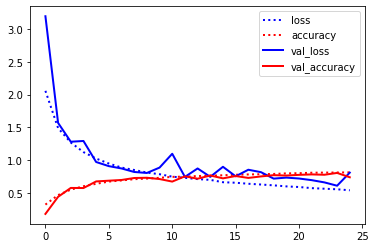

In [20]:
import pandas as pd
import numpy as np
pd.DataFrame(history.history).plot(lw=2,style=['b:','r:','b-','r-']);
print("Max val_acc",np.max(history.history['val_accuracy']))

We get 2-3% improvement. We get the best results with very subtle data augmentation (small shifts and flips). The images are quite low resolution and rotation or sheer will destroy too much information.

## Exercise 5: Interpreting misclassifications
Chances are that even your best models are not yet perfect. It is important to understand what kind of errors it still makes.
* Run the test images through the network and detect all misclassified ones
* Interpret the results. Are these misclassifications to be expected? 
* Compute the confusion matrix. Which classes are often confused?

In [21]:
y_pred = model.predict(X_test)
misclassified_samples = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]

Since we have numeric outputs (a value per class), we need to take the class with the maximum value as the predicted class.

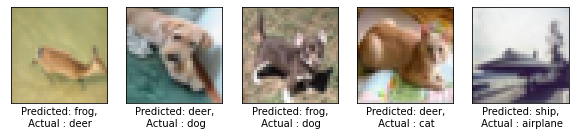

In [22]:
# Visualize the (first five) misclassifications, together with the predicted and actual class
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for nr, i in enumerate(misclassified_samples[:5]):
    axes[nr].imshow(X_test[i])
    axes[nr].set_xlabel("Predicted: %s,\n Actual : %s" % (cifar_classes[np.argmax(y_pred[i])],cifar_classes[np.argmax(y_test[i])]))
    axes[nr].set_xticks(()), axes[nr].set_yticks(())

plt.show();

Some of these are indeed hard to categorize, although we can probably still improve the model quite a bit.

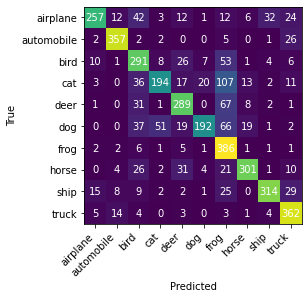

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
ax.set_xticklabels(list(cifar_classes.values()), rotation=45, ha="right")
ax.set_yticklabels(list(cifar_classes.values()))
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
for i in range(100):
    ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")

Most misclassifications seem to involve cats, birds, and horses. The most common misclassification is between cats and dogs.

## Exercise 6: Interpreting the model
Retrain your best model on all the data. Next, retrieve and visualize the activations (feature maps) for every filter for every layer, or at least for a few filters for every layer. Tip: see the course notebooks for examples on how to do this. 

Interpret the results. Is your model indeed learning something useful?

In [24]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_28 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                      

In [25]:
from tensorflow.keras import models

img_tensor = X_test[4]
img_tensor = np.expand_dims(img_tensor, axis=0) 

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:15]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

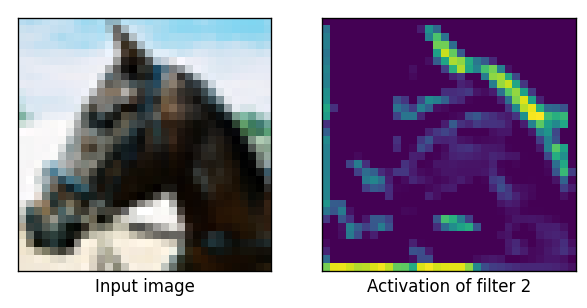

In [26]:
plt.rcParams['figure.dpi'] = 120
first_layer_activation = activations[0]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(img_tensor[0])
ax2.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_xlabel('Input image')
ax2.set_xlabel('Activation of filter 2');

In [27]:
images_per_row = 16

layer_names = []
for layer in model.layers[:15]:
    layer_names.append(layer.name)

def plot_activations(layer_index, activations):
    start = layer_index
    end = layer_index+1
    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names[start:end], activations[start:end]):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title("Activation of layer {} ({})".format(layer_index+1,layer_name))
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()

/var/folders/0t/5d8ttqzd773fy0wq3h5db0xr0000gn/T/ipykernel_34025/2702396986.py:30: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


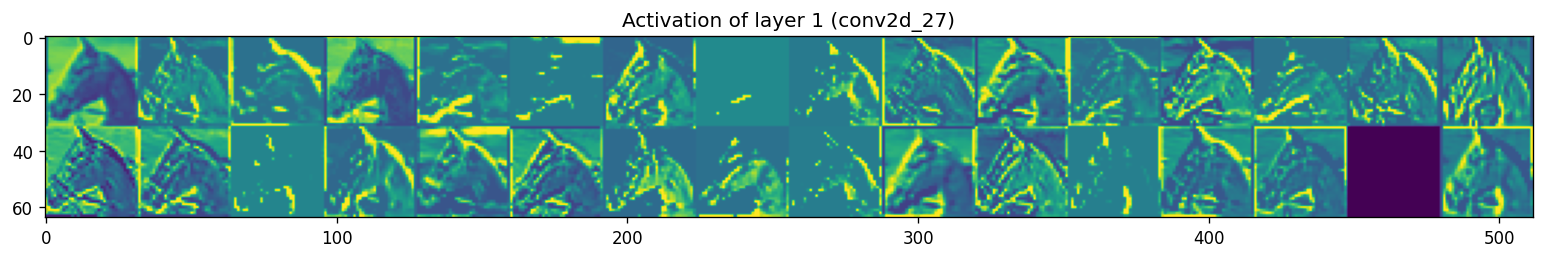

In [28]:
plot_activations(0, activations);

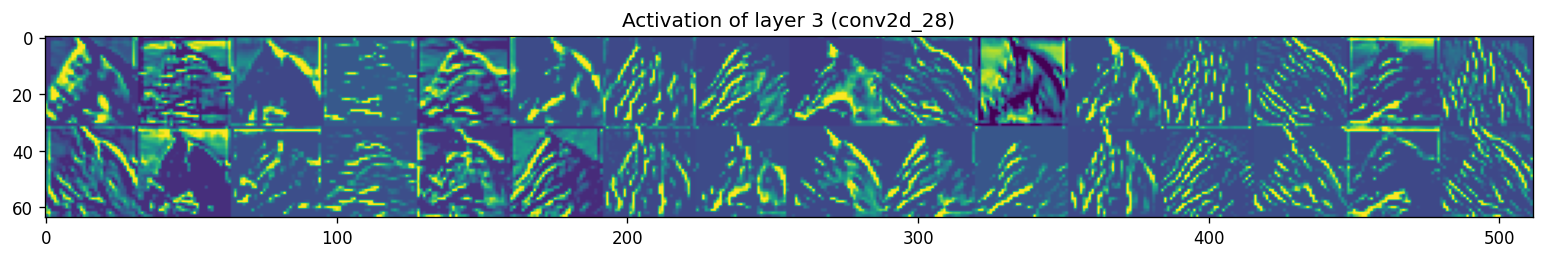

In [29]:
plot_activations(2, activations);

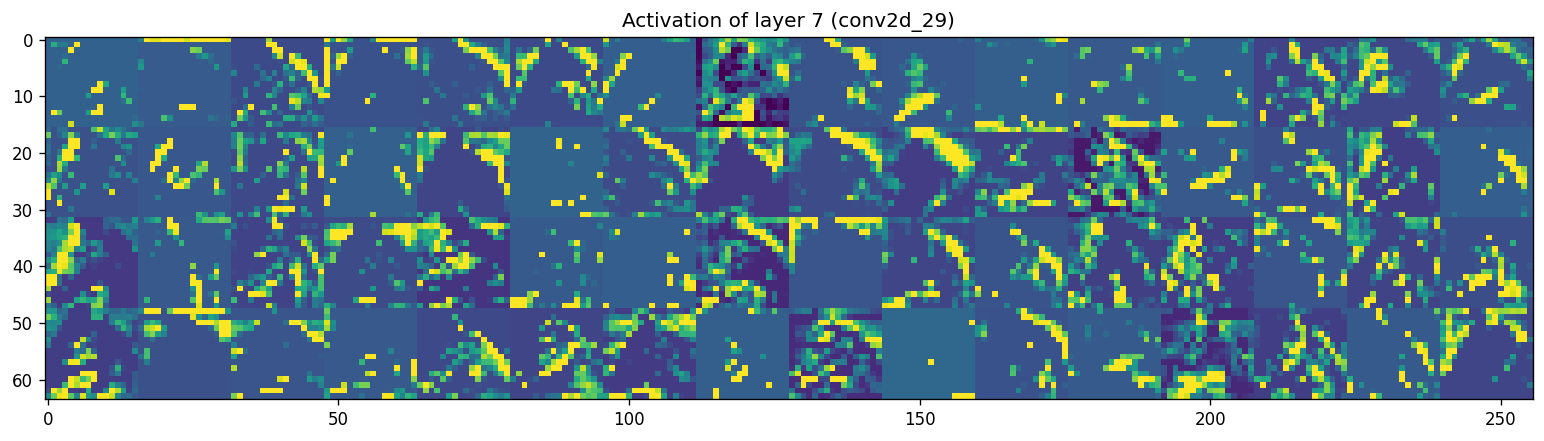

In [30]:
plot_activations(6, activations);

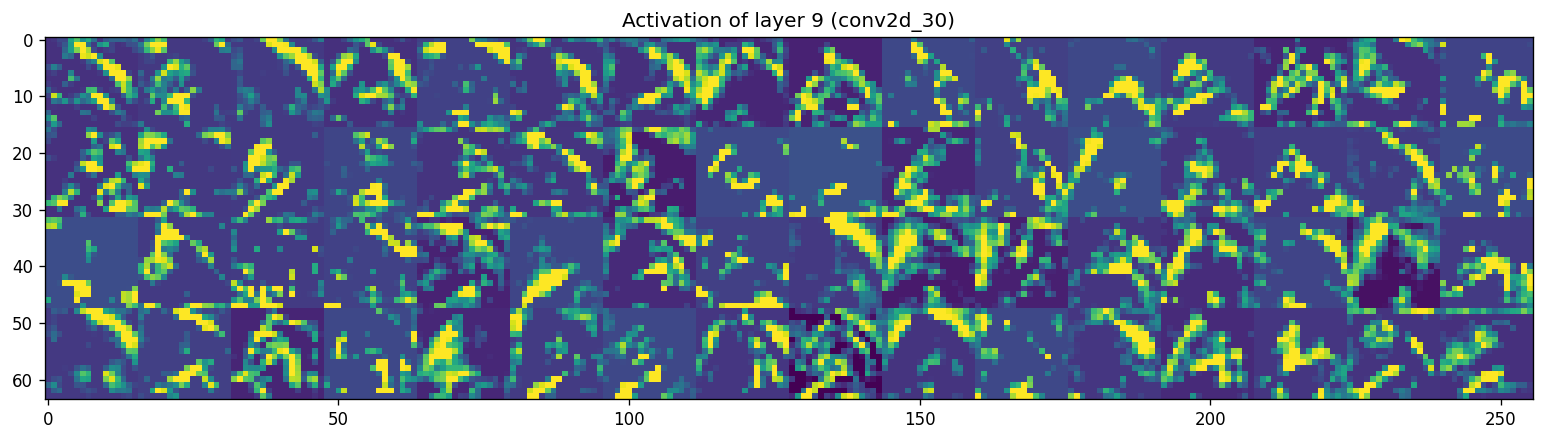

In [31]:
plot_activations(8, activations)

/var/folders/0t/5d8ttqzd773fy0wq3h5db0xr0000gn/T/ipykernel_34025/2702396986.py:30: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


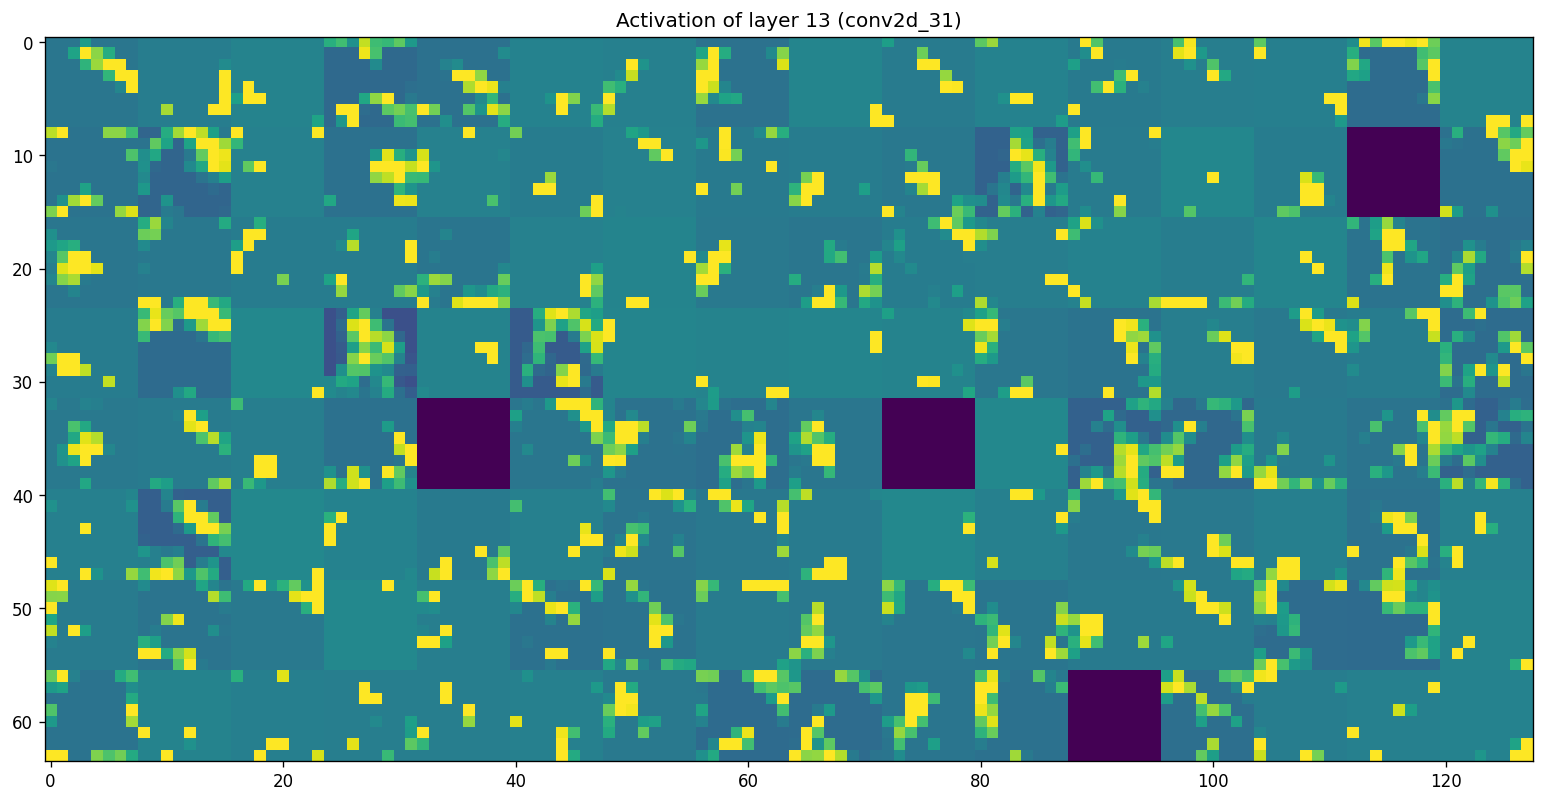

In [32]:
plot_activations(12, activations)

## Optional: Take it a step further
* Repeat the exercises, but now use a [higher-resolution version of the CIFAR dataset](https://www.openml.org/d/40926) (with OpenML ID 41103), or another [version with 100 classes](https://www.openml.org/d/41983) (with OpenML ID 41983). Good luck!
